In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import io
from sklearn.linear_model import LinearRegression



In [2]:
url = "https://cdn.cboe.com/api/global/us_indices/daily_prices/VIX_History.csv"
download = requests.get(url).content
vix_df = pd.read_csv(io.StringIO(download.decode('utf-8')))
vix_df.rename(columns={'CLOSE': 'VIX'}, inplace=True)
vix_df.rename(columns={'DATE': 'date'}, inplace=True)
vix_df = vix_df[['date', 'VIX']]
vix_df['date'] = pd.to_datetime(vix_df['date'])
vix_df['VIX'] = vix_df['VIX'].astype(float)
vix_df.head()

,date,VIX
0,1990-01-02,17.24
1,1990-01-03,18.19
2,1990-01-04,19.22
3,1990-01-05,20.11
4,1990-01-08,20.26


In [3]:
def generate_ou_paths(S0, mu, theta, sigma, T, dt, n_simulations):
    n_steps = int(T / dt)
    paths = np.zeros((n_steps + 1, n_simulations))
    paths[0] = S0
    for t in range(1, n_steps + 1):
        dW = np.random.normal(scale=np.sqrt(dt), size=n_simulations)
        paths[t] = paths[t - 1] + theta * (mu - paths[t - 1]) * dt + sigma * dW
        min_vix_value = 10
        paths[t] = np.clip(paths[t - 1] + theta * (mu - paths[t - 1]) * dt + sigma * dW, min_vix_value, None)
    return paths

           0          1          2       date
0  20.000000  20.000000  20.000000 1990-01-02
1  20.900530  18.741412  19.605328 1990-01-03
2  19.660298  19.603905  19.697483 1990-01-04
3  20.172020  19.345729  18.819017 1990-01-05
4  21.244468  20.040390  18.765301 1990-01-08


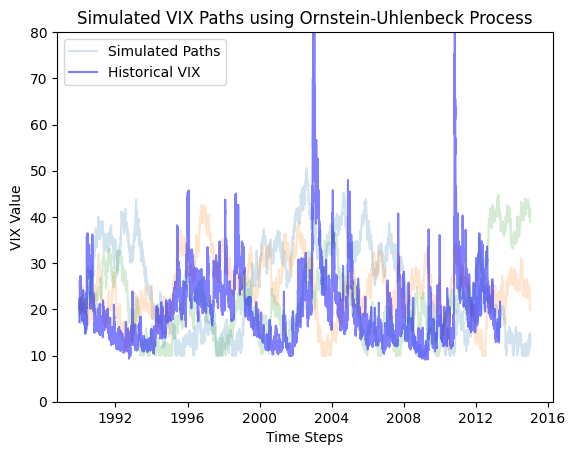

In [4]:
#  Example usage
np.random.seed() # For reproducible results
S0 = 20  # Initial VIX value, can be the latest value from your historical data
mu = 20  # Long-term mean of VIX
theta = 0.5  # Speed of mean reversion
sigma = 10  # Volatility
T = 25  # Time horizon in years
dt = 1/252  # Daily time step
n_simulations = 3  # Number of simulated paths
simulated_paths = generate_ou_paths(S0, mu, theta, sigma, T, dt, n_simulations)
paths_df = pd.DataFrame(simulated_paths)
paths_df['date'] = vix_df['date']
print(paths_df.head())
# Plot simulated paths
date_range = pd.date_range(start=vix_df['date'][0], periods=len(vix_df), freq='D')
for i in range(n_simulations):
    plt.plot(paths_df['date'],simulated_paths[:, i], alpha=0.2,  label='Simulated Paths' if i == 0 else None)
plt.xlabel('Time Steps')
plt.ylabel('VIX Value')
plt.ylim(0, 80)
plt.title('Simulated VIX Paths using Ornstein-Uhlenbeck Process')

# Add historical data to the plot
plt.plot(date_range, vix_df['VIX'], color='blue', label='Historical VIX', alpha=0.5)
plt.legend()
plt.show()

In [5]:
def estimate_ou_parameters(vix_df, dt=1/252):
    """
    Estimate parameters of the Ornstein-Uhlenbeck process from VIX historical data.

    :param vix_df: Historical VIX data (numpy array or Pandas series)
    :param dt: Time step (default is daily for 252 trading days in a year)
    :return: Tuple of (mu, theta, sigma)
    """
    # Calculate differences
    delta_X = np.diff(vix_df)
    X_lagged = vix_df[:-1]

    # Linear regression
    model = LinearRegression().fit(X_lagged.reshape(-1, 1), delta_X)
    b = model.coef_[0]
    a = model.intercept_

    # Solving for mu and theta
    theta = -b / dt
    mu = a / (theta * dt)

    # Estimate sigma
    residuals = delta_X - (a + b * X_lagged)
    sigma = np.std(residuals) / np.sqrt(dt)

    return mu, theta, sigma

mu, theta, sigma = estimate_ou_parameters(vix_df['VIX'].values)
print(f"Estimated parameters: mu = {mu}, theta = {theta}, sigma = {sigma}")


Estimated parameters: mu = 19.622844114085552, theta = 5.423327524426365, sigma = 25.928557745336644


           0       date
0  20.000000 1990-01-02
1  18.699802 1990-01-03
2  20.547534 1990-01-04
3  20.336586 1990-01-05
4  20.734341 1990-01-08


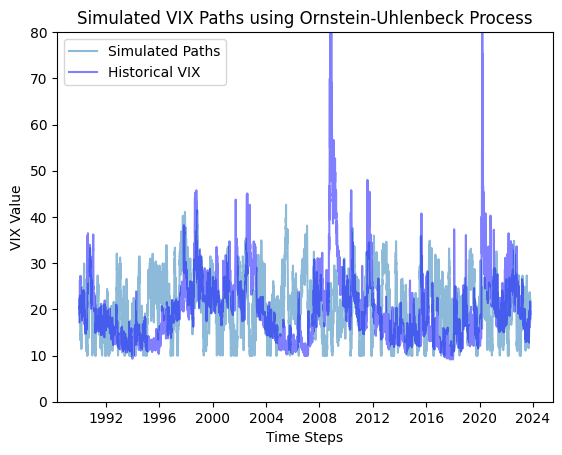

In [6]:
# Generate paths
np.random.seed() # For reproducible results
S0 = 20  # Initial VIX value, can be the latest value from your historical data
T = 35  # Time horizon in years
dt = 1/252  # Daily time step
n_simulations = 1  # Number of simulated paths
simulated_paths = generate_ou_paths(S0, mu, theta, sigma, T, dt, n_simulations)
paths_df = pd.DataFrame(simulated_paths)
paths_df['date'] = vix_df['date']
min_vix_value = 10

print(paths_df.head())

# Plot simulated paths
date_range = pd.date_range(start=vix_df['date'][0], periods=len(vix_df), freq='D')

for i in range(n_simulations):
    plt.plot(paths_df['date'],simulated_paths[:, i], alpha=0.5,  label='Simulated Paths' if i == 0 else None)
plt.xlabel('Time Steps')
plt.ylabel('VIX Value')
plt.ylim(0, 80)
plt.title('Simulated VIX Paths using Ornstein-Uhlenbeck Process')

# Add historical data to the plot
plt.plot(vix_df['date'], vix_df['VIX'], color='blue', label='Historical VIX', alpha=0.5)
plt.legend()

plt.show()

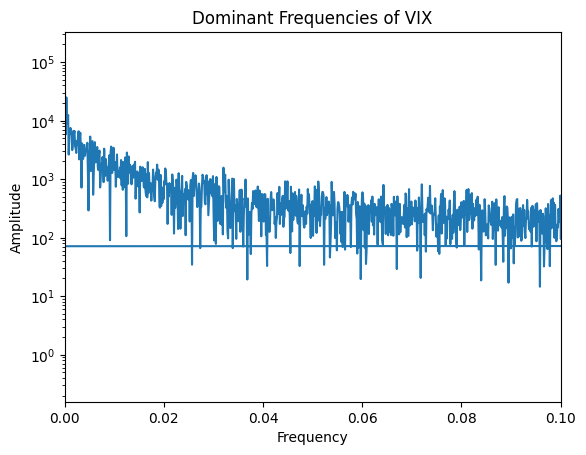

In [7]:
vix_fft = np.fft.fft(vix_df['VIX'].values)

# Get frequencies
n = len(vix_fft)
freq = np.fft.fftfreq(n)

# Plot dominant frequencies
plt.plot(freq, np.abs(vix_fft))
plt.xlim(0, 0.1)
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.yscale('log')
plt.title('Dominant Frequencies of VIX')
plt.show()


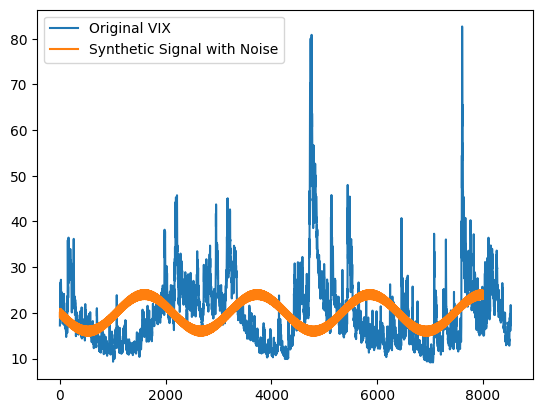

In [8]:
import numpy as np
# import matplotlib.pyplot as plt

# Generate a synthetic VIX data for demonstration (replace with your VIX data)
vix_data = vix_df['VIX'].values

# Apply FFT
vix_fft = np.fft.fft(vix_data)
frequencies = np.fft.fftfreq(len(vix_fft))

# Identify main frequency (for simplicity, we just find the maximum)
main_frequency = frequencies[np.argmax(np.abs(vix_fft[1:]) + 1)]  # Excluding the 0 frequency

# Create a synthetic carrier
carrier = np.sin(2 * np.pi * main_frequency * np.arange(8000))*4+20

# Add higher amplitude noise at a different frequency
noise_frequency = main_frequency + 0.73  # Example
noise = np.sin(2 * np.pi * noise_frequency * np.arange(8000))  # Higher amplitude than carrier

synthetic_signal = carrier + noise

# Plot
plt.plot(vix_data, label="Original VIX")
plt.plot(synthetic_signal, label="Synthetic Signal with Noise")
plt.legend()
plt.show()


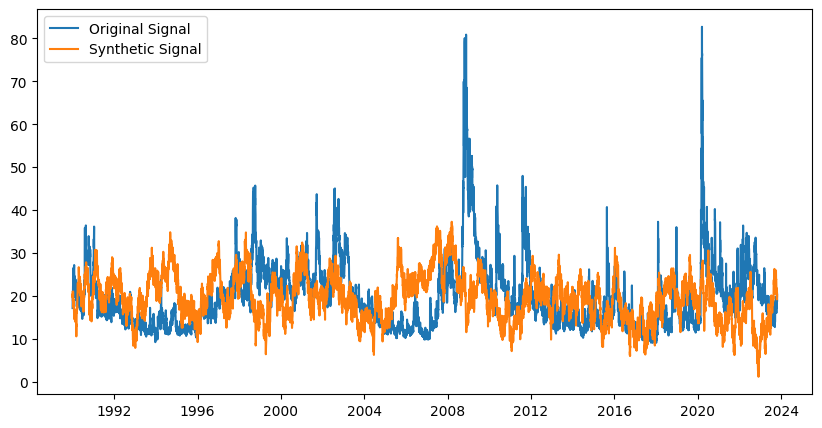

In [9]:

def generate_synthetic_signal(original_signal):
    # Step 1: Compute the FFT of the original signal
    signal_fft = np.fft.fft(original_signal)
    
    # Step 2: Randomize the phase
    random_phases = np.exp(1j * (np.angle(signal_fft) + 2 * np.pi * np.random.rand(*signal_fft.shape)))
    synthetic_spectrum = np.abs(signal_fft) * random_phases
    
    # Step 3: Compute the inverse FFT
    synthetic_signal = np.fft.ifft(synthetic_spectrum).real
    
    return synthetic_signal

# Generate a sample signal for demonstration
# time = np.arange(0, 10, 0.01)
time = vix_df['date'].values
# original_signal = np.sin(time) + 0.5 * np.sin(5 * time)  # This is just a sample signal
original_signal = vix_df['VIX'].values

synthetic_signal = generate_synthetic_signal(original_signal)
# we shift up the synthetic signal to match the original signal
synthetic_signal = synthetic_signal + (original_signal.mean() - synthetic_signal.mean())

# Plot
plt.figure(figsize=(10, 5))
plt.plot(time, original_signal, label='Original Signal')
plt.plot(time, synthetic_signal, label='Synthetic Signal')
plt.legend()
plt.show()


Number of spikes in original signal: 203
Number of spikes in synthetic signal: 203
0    17.24
1    18.19
2    19.22
3    20.11
4    20.26
Name: VIX, dtype: float64


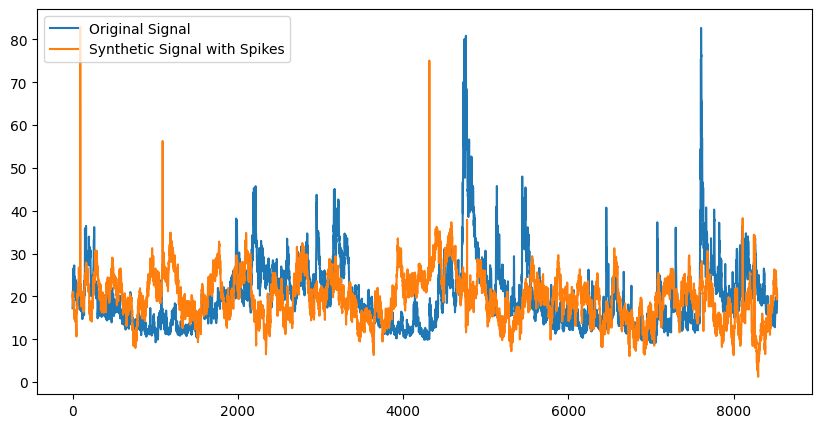

In [10]:
def add_spikes_to_signal(signal, num_spikes, spike_magnitude):
    # Generate random positions for spikes
    spike_positions = np.random.choice(len(signal), num_spikes, replace=False)
    
    # Generate random magnitudes for spikes
    spike_values = np.random.choice([spike_magnitude*0.8, spike_magnitude], num_spikes)
    
    # Add spikes to the signal
    signal_with_spikes = signal.copy()
    for pos, val in zip(spike_positions, spike_values):
        signal_with_spikes[pos] += val
        
    return signal_with_spikes

threshold = 40  # Adjust based on original data
# diff_signal = np.diff(original_signal)
num_spikes_original = len(np.where(np.abs(vix_df['VIX'].values) > threshold)[0])
# we count how many times vix is above the threshold
num_spikes = len(np.where(np.abs(vix_df['VIX'].values) > threshold)[0])
print(f"Number of spikes in original signal: {num_spikes_original}")
print(f"Number of spikes in synthetic signal: {num_spikes}")
print(vix_df['VIX'].head())

# Add spikes to synthetic signal
synthetic_signal_with_spikes = add_spikes_to_signal(synthetic_signal, 5, 30)

# Add spikes to synthetic signal
synthetic_signal_with_spikes = add_spikes_to_signal(synthetic_signal_with_spikes, 2, 60)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(original_signal, label='Original Signal')
plt.plot(synthetic_signal_with_spikes, label='Synthetic Signal with Spikes')
plt.legend()
plt.show()


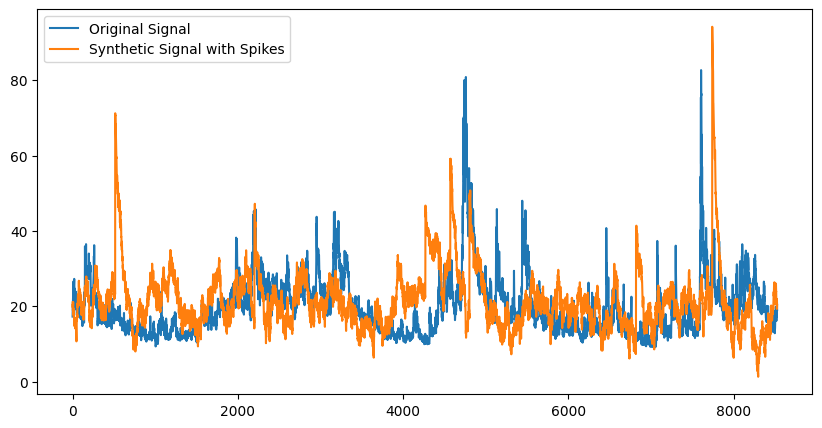

In [11]:
def add_spikes_to_signal(signal, num_spikes, spike_magnitude, decay_rate=0.985):
    # Generate random positions for spikes
    spike_positions = np.random.choice(len(signal), num_spikes, replace=False)
  
    # Generate random magnitudes for spikes
    spike_values = np.random.choice([spike_magnitude*0.8, spike_magnitude, spike_magnitude*1.2], num_spikes)
    
    # Add spikes to the signal
    signal_with_spikes = signal.copy()
    for pos, val in zip(spike_positions, spike_values):
        signal_with_spikes[pos] += val
        # Apply decay to subsequent points
        decay_val = val
        for i in range(1, 175):  # 50 is an arbitrary number; adjust for how long you want the decay
            if pos+i < len(signal):
                decay_val *= decay_rate
                signal_with_spikes[pos+i] += decay_val
            else:
                break
                
    return signal_with_spikes


synthetic_signal_with_spikes = add_spikes_to_signal(synthetic_signal, 5, 30)
synthetic_signal_with_spikes = add_spikes_to_signal(synthetic_signal_with_spikes, 2, 60)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(original_signal, label='Original Signal')
plt.plot(synthetic_signal_with_spikes, label='Synthetic Signal with Spikes')
plt.legend()
plt.show()


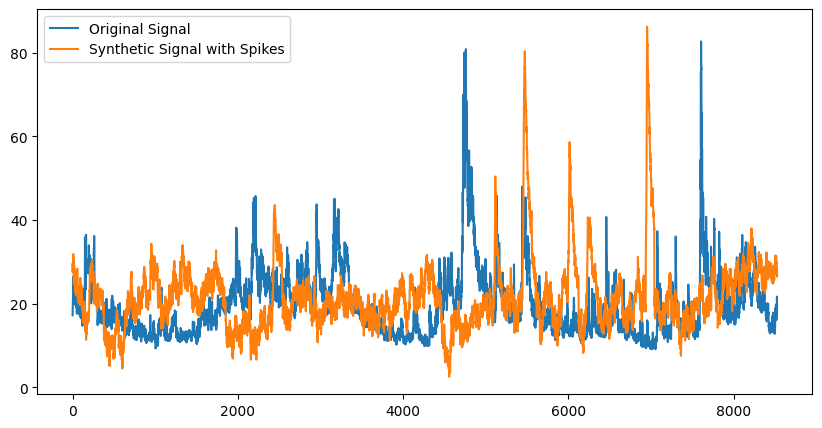

In [12]:
def add_spikes_to_signal(signal, num_spikes, spike_magnitude, in_decay_rate=0.9, out_decay_rate=0.985):
    # Generate random positions for spikes
    spike_positions = np.random.choice(len(signal), num_spikes, replace=False)
  
    # Generate random magnitudes for spikes
    spike_values = np.random.choice([spike_magnitude*0.8, spike_magnitude, spike_magnitude*1.2], num_spikes)
    
    signal_with_spikes = signal.copy()
    for pos, val in zip(spike_positions, spike_values):
        signal_with_spikes[pos] += val

        decay_val = val
        decay_length = np.random.randint(75, 175)  # Varying decay length

        # Decay to the right
        for i in range(1, int(decay_length)):  
            if pos+i < len(signal):
                decay_val *= out_decay_rate
                signal_with_spikes[pos+i] += decay_val
            else:
                break

        # Decay to the left (before the spike)
        decay_val = val
        for i in range(1, int(decay_length*0.2)):  
            if pos-i >= 0:
                decay_val *= in_decay_rate
                signal_with_spikes[pos-i] += decay_val
            else:
                break
                
    return signal_with_spikes

synthetic_signal = generate_synthetic_signal(original_signal)
# we shift up the synthetic signal to match the original signal
synthetic_signal = synthetic_signal + (original_signal.mean() - synthetic_signal.mean())

synthetic_signal_with_spikes = add_spikes_to_signal(synthetic_signal, 5, 30)
synthetic_signal_with_spikes = add_spikes_to_signal(synthetic_signal_with_spikes, 2, 55)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(original_signal, label='Original Signal')
plt.plot(synthetic_signal_with_spikes, label='Synthetic Signal with Spikes')
plt.legend()
plt.show()


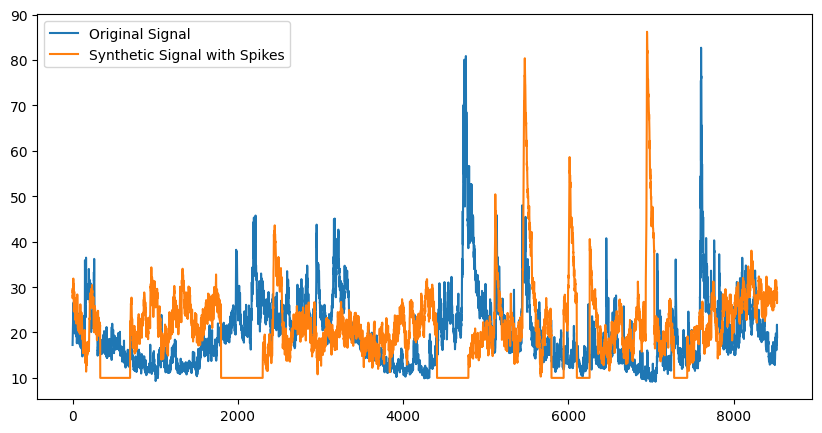

In [13]:
def apply_floor_with_blending(signal, floor_value=10, decay_rate=0.985):
    blended_signal = signal.copy()

    below_floor = np.where(blended_signal < floor_value)[0]
    
    for idx in below_floor:
        blended_signal[idx] = floor_value
        
        # Apply decay before (to the left of the floor)
        decay_val = floor_value - signal[idx]
        for i in range(1, 75):  # 75 is arbitrary, adjust based on desired decay length
            if idx-i >= 0:
                decay_val *= decay_rate
                blended_signal[idx-i] += min(decay_val, floor_value - blended_signal[idx-i])
            else:
                break
                
        # Apply decay after (to the right of the floor)
        decay_val = floor_value - signal[idx]
        for i in range(1, 75):  
            if idx+i < len(signal):
                decay_val *= decay_rate
                blended_signal[idx+i] += min(decay_val, floor_value - blended_signal[idx+i])
            else:
                break

    return blended_signal
blended_signal = apply_floor_with_blending(synthetic_signal_with_spikes)
plt.figure(figsize=(10, 5))
plt.plot(original_signal, label='Original Signal')
plt.plot(blended_signal, label='Synthetic Signal with Spikes')
plt.legend()
plt.show()

556


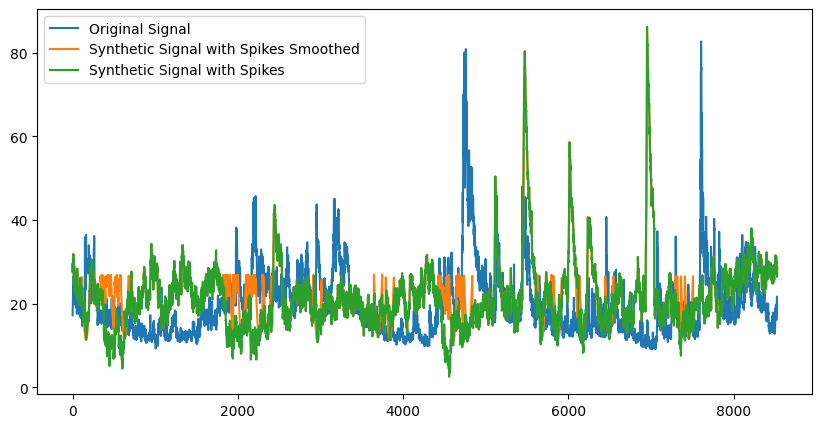

In [14]:
def smooth_bottoms(signal, threshold=12, width=100):
    smoothed_signal = signal.copy()
    sharp_bottoms = np.where(signal < threshold)[0]
    print(len(sharp_bottoms))

    # For each detected point, smoothen the region around it
    for idx in sharp_bottoms:
        # Create a U-shape using a quadratic function
        left = max(0, idx - width // 2)
        right = min(len(signal), idx + width // 2)
        x = np.linspace(-width // 2, width // 2, right - left)
        y = 0.006 * x**2 + signal[idx] #+ #x * 0.005 * signal[idx]

        # Update the signal with the U-shape
        smoothed_signal[left:right] = y

    return smoothed_signal
synthetic_signal_smoothed = smooth_bottoms(synthetic_signal_with_spikes)
plt.figure(figsize=(10, 5))
plt.plot(original_signal, label='Original Signal')
plt.plot(synthetic_signal_smoothed, label='Synthetic Signal with Spikes Smoothed')
plt.plot(synthetic_signal_with_spikes, label='Synthetic Signal with Spikes')
plt.legend()
plt.show()

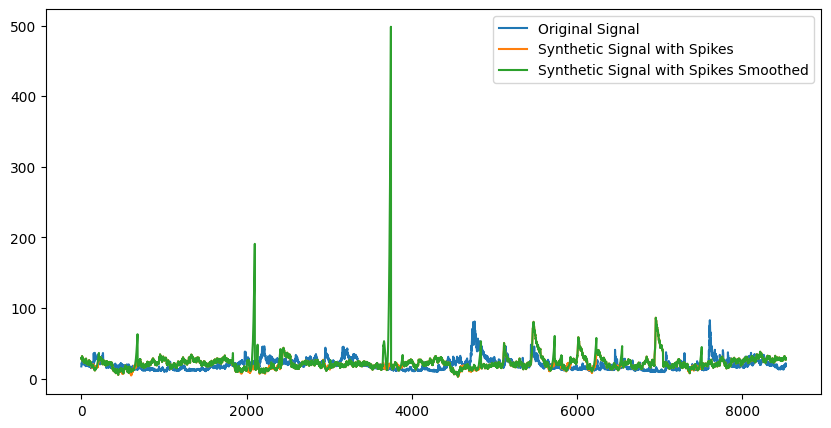

In [15]:
def smooth_bottoms2(signal, threshold=12, width=100):
    smoothed_signal = signal.copy()
    sharp_bottoms = np.where(signal < threshold)[0]

    # For each detected point, smoothen the region around it
    for idx in sharp_bottoms:
        # The curvature is inversely proportional to the difference
        # between the detected value and the threshold. 
        # The larger the difference, the smaller the curvature.
        curvature = 0.002 + 0.005 / (threshold - signal[idx] + 0.005)
        
        # Create a U-shape using a quadratic function
        left = max(0, idx - width // 2)
        right = min(len(signal), idx + width // 2)
        x = np.linspace(-width // 2, width // 2, right - left)
        y = curvature * x**2 + signal[idx]

        # Blend the generated U shape with the original signal
        alpha = np.linspace(0, 1, len(y))
        smoothed_signal[left:right] = alpha * y + (1 - alpha) * signal[left:right]

    return smoothed_signal

synthetic_signal_smoothed = smooth_bottoms2(synthetic_signal_with_spikes)
plt.figure(figsize=(10, 5))
plt.plot(original_signal, label='Original Signal')
plt.plot(synthetic_signal_with_spikes, label='Synthetic Signal with Spikes')
plt.plot(synthetic_signal_smoothed, label='Synthetic Signal with Spikes Smoothed')

plt.legend()
plt.show()


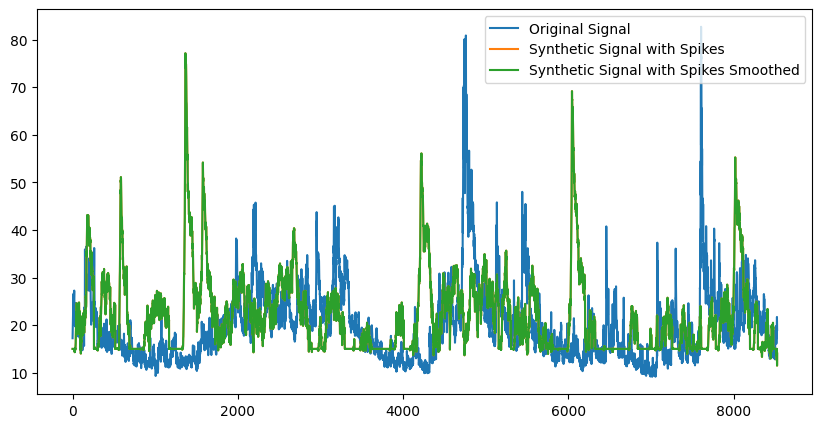

In [18]:
def smooth_bottoms_by_derivative(signal, threshold=10, blend_width=100):
    # Calculate the first derivative
    derivative = np.diff(signal)
    # Detect points where there's a change in sign, indicating a peak
    peaks = np.where(np.diff(np.sign(derivative)) > 0)[0]

    # For each detected peak, check if it's below the threshold
    for idx in peaks:
        if signal[idx] < threshold:
            signal[idx] = threshold
            # Blend on both sides of the peak
            left = max(0, idx - blend_width // 2)
            right = min(len(signal), idx + blend_width // 2)
            # Generate linear blending factors
            blend_factors = np.linspace(0, 1, right - left)
            # Blend using a weighted average of the signal and the threshold
            signal[left:right] = blend_factors * signal[left:right] + (1 - blend_factors) * threshold
            
    return signal


synthetic_signal = generate_synthetic_signal(original_signal)
synthetic_signal = synthetic_signal + (original_signal.mean() - synthetic_signal.mean())
synthetic_signal_with_spikes = add_spikes_to_signal(synthetic_signal, 5, 30)
synthetic_signal_with_spikes = add_spikes_to_signal(synthetic_signal_with_spikes, 2, 55)
synthetic_signal_smoothed = smooth_bottoms_by_derivative(synthetic_signal_with_spikes, 15, 50)

plt.figure(figsize=(10, 5))
plt.plot(original_signal, label='Original Signal')
plt.plot(synthetic_signal_with_spikes, label='Synthetic Signal with Spikes')
plt.plot(synthetic_signal_smoothed, label='Synthetic Signal with Spikes Smoothed')

plt.legend()
plt.show()
